In [337]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [338]:
import os
from pathlib import Path
import random

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

import project_inits
from pyscite.scite import Scite, SciteException

import seaborn as sns
import matplotlib.pyplot as plt

/home/asura/Projects/scholcommlab/content-based-citations/.venv/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [339]:
# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

sns.set_style("whitegrid")

sns.set(
    font_scale=1.5,
    rc={
        "font.family": "sans-serif",
        "font.size": 16.0,
        "figure.figsize": (11.69, 8.27),
    }
)

### Setup

Choose a sample of 1000 DOIs from the ALS dataset (which contains full references for 5000 articles)

In [184]:
# The data directory for this specific notebook
nb_dir = data_dir / "weighted_citations"

Select a random sample and save it as the base dataset for this notebook. Copy & paste this code block to create a different DOI selection

```python
selection = als_dois.DOI.sample(1000).tolist()

print("n references:", len(refs[refs.target.isin(selection)]))
print("total citing papers:", refs[refs.target.isin(selection)].source.nunique())

print("missing citing papers:", refs[refs.target.isin(selection)].source.nunique()-len(selection))

pd.DataFrame({"doi":selection}).to_csv(nb_dir / "1000_doi_sample.csv", index=False)
```

### Load datasets

In [188]:
# Load ALS DOIs
sample_refs = pd.read_csv(als_dir / "citations.csv")

selection = pd.read_csv(nb_dir / "1000_doi_sample.csv").doi

sel_refs = sample_refs[sample_refs.target.isin(selection)]

#### Cited articles

In [122]:
SCITE_KEY = os.getenv("SCITE_KEY")
TOOL = os.getenv("TOOL")
EMAIL = os.getenv("EMAIL")

scite = Scite(SCITE_KEY)

In [177]:
failed_dois = {}
ref_counts = pd.DataFrame(columns=["total_references", "total_citations"])

doi_list = sel_refs.source.unique().tolist()

outfile = nb_dir / "citations.jsonl"
scite.get_dois(doi_list, , overwrite=True)

100%|██████████| 9945/9945 [10:28<00:00, 15.82it/s]


In [365]:
with open(nb_dir / "citations.jsonl") as f:
    data = ndjson.load(f)
incoming_refs = pd.DataFrame.from_records(data)
incoming_refs

,id,negative,neutral,positive,section,snippet,source,target,type,typeConfidence,expertClassification
0,2151417907,0.000605,1.0,0.000917,1. Introduction\n,Gliotoxin (GTX) is a mycotoxin that was origin...,10.3390/toxins11080443,10.1111/1462-2920.13080,mentioning,1.0,NaN
1,2151417908,0.000344,1.0,0.000467,1. Introduction\n,"However, it has been lately described that it ...",10.3390/toxins11080443,10.1182/blood-2004-09-3421,mentioning,1.0,NaN
2,2151417909,0.000730,1.0,0.000409,1. Introduction\n,GTX is considered a virulence factor; it inten...,10.3390/toxins11080443,10.1016/j.molimm.2011.07.005,mentioning,1.0,NaN
3,2151417910,0.000714,1.0,0.000404,1. Introduction\n,GTX is considered a virulence factor; it inten...,10.3390/toxins11080443,10.1016/j.jneuroim.2015.05.008,mentioning,1.0,NaN
4,2151417911,0.000341,1.0,0.000522,1. Introduction\n,CNS fungal infections are associated with cons...,10.3390/toxins11080443,10.1016/b978-0-7020-4088-7.00095-x,mentioning,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1236716,2154611948,0.002866,1.0,0.001454,2. Transcriptomics—One Major Pillar in Evoluti...,"As a consequence, methodological limitations o...",10.3390/toxins10070292,10.1093/gbe/evx279,mentioning,1.0,NaN
1236717,2155471430,0.013926,1.0,0.020408,Introduction\n,"Among these, programs founded in machine learn...",10.7717/peerj.5361,10.1093/gbe/evx279,mentioning,1.0,NaN
1236718,2155471533,0.001344,1.0,0.000853,Discussion\n,Despite having multiple assembly or expression...,10.7717/peerj.5361,10.1093/gbe/evx279,mentioning,1.0,NaN
1236719,2193158402,0.052508,1.0,0.019153,Discussion,Fireworms are therefore unwanted inhabitants i...,10.3897/neobiota.61.57682,10.1093/gbe/evx279,mentioning,1.0,NaN


In [438]:
citing_articles = pd.DataFrame({"doi":sel_refs.source.unique().tolist()}).set_index("doi")
citing_articles["total_references"] = incoming_refs[incoming_refs.source.isin(doi_list)].groupby("source").size()
citing_articles["total_citations"] = incoming_refs[incoming_refs.source.isin(doi_list)].groupby("source").target.nunique()
citing_articles["refs_per_citation"] = citing_articles["total_references"] / citing_articles["total_citations"]

# Remove citing articles underneat the 1st quantile of total outgoing references
citing_articles = citing_articles[citing_articles.total_references>citing_articles.total_references.quantile(0.01)]

### Weighted Citations

In [446]:
source_target_counts = sel_refs.groupby("target")["source"].value_counts().to_frame("mentions").reset_index()

# merge with total reference counts for citing articles
source_target_counts = source_target_counts.set_index("source").join(citing_articles[["total_references", "total_citations", "refs_per_citation"]], how="inner")
source_target_counts = source_target_counts.reset_index().rename(columns={"index":"source"})
source_target_counts = source_target_counts.rename(columns={"total_references":"total_mentions"})

# Cleanup
source_target_counts = source_target_counts.dropna()
source_target_counts = source_target_counts[source_target_counts.total_mentions!=0]

# Calculate the weighted mentions
source_target_counts["weighted_mentions"] = source_target_counts["mentions"] / source_target_counts["total_mentions"]
source_target_counts["weighted_citations"] = source_target_counts["total_citations"] * source_target_counts["weighted_mentions"]

source_target_counts["weighted_citation_ratio"] = source_target_counts["weighted_citations"] / source_target_counts["refs_per_citation"]

In [451]:
source_target_counts

,source,target,mentions,total_mentions,total_citations,refs_per_citation,weighted_mentions,weighted_citations,weighted_citation_ratio
0,10.1001/jama.2017.20885,10.1093/jnen/nlx101,1,34.0,25.0,1.360000,0.029412,0.735294,0.540657
1,10.1001/jama.2019.16161,10.1038/ng.3482,3,22.0,9.0,2.444444,0.136364,1.227273,0.502066
2,10.1001/jamadermatol.2018.4673,10.1186/s13023-017-0718-x,1,29.0,20.0,1.450000,0.034483,0.689655,0.475624
3,10.1001/jamanetworkopen.2019.6972,10.1089/jpm.2017.0548,1,46.0,42.0,1.095238,0.021739,0.913043,0.833648
4,10.1001/jamaneurol.2018.0035,10.1172/jci.insight.89530,1,56.0,29.0,1.931034,0.017857,0.517857,0.268176
...,...,...,...,...,...,...,...,...,...
10878,10.7759/cureus.6906,10.1155/2016/7471842,2,11.0,7.0,1.571429,0.181818,1.272727,0.809917
10879,10.7916/d8tb1k44,10.1186/s40360-016-0099-0,1,170.0,77.0,2.207792,0.005882,0.452941,0.205156
10880,10.7916/d8vd8ff5,10.1212/wnl.0000000000004179,1,175.0,123.0,1.422764,0.005714,0.702857,0.494008
10881,10.7916/tohm.v0.712,10.3390/ijms17020189,1,39.0,29.0,1.344828,0.025641,0.743590,0.552926


In [433]:
articles.describe()

,references,citations,refs_per_citation,agg_weighted_citations,mean_weighted_citations
count,993.000000,993.000000,993.000000,993.000000,993.000000
mean,18.127895,11.088620,1.665925,11.592799,1.073666
std,32.163248,18.684137,1.068416,20.033557,0.518450
min,1.000000,1.000000,1.000000,0.363636,0.363636
25%,4.000000,3.000000,1.125000,2.975710,0.816234
50%,10.000000,6.000000,1.428571,6.382203,0.962044
75%,19.000000,12.000000,1.800000,12.764695,1.160486
max,554.000000,304.000000,19.000000,345.856673,7.602674


In [434]:
articles[articles.agg_weighted_citations>6].corr(method="spearman")

,references,citations,refs_per_citation,agg_weighted_citations,mean_weighted_citations
references,1.000000,0.858635,0.238333,0.971315,0.157758
citations,0.858635,1.000000,-0.235856,0.893429,-0.275813
refs_per_citation,0.238333,-0.235856,1.000000,0.130519,0.906140
agg_weighted_citations,0.971315,0.893429,0.130519,1.000000,0.122382
mean_weighted_citations,0.157758,-0.275813,0.906140,0.122382,1.000000


In [368]:
articles = pd.DataFrame(index=selection)

articles['references'] = sel_refs.groupby("target")["source"].size()
articles['citations'] = sel_refs.groupby("target").source.nunique()
articles['refs_per_citation'] = articles.references / articles.citations

# Aggregate weighted_counts
articles["agg_weighted_citations"] = source_target_counts.groupby("target")["weighted_citations"].sum()

# Mean weighted_counts
articles["mean_weighted_citations"] = source_target_counts.groupby("target")["weighted_citations"].apply(lambda x: x.mean())

articles = articles.dropna()

articles

,references,citations,refs_per_citation,agg_weighted_citations,mean_weighted_citations
doi,,,,,
10.1371/journal.pone.0159593,1,1,1.000000,0.854545,0.854545
10.1080/21541248.2016.1276999,44,28,1.571429,30.894701,1.103382
10.1101/gad.281030.116,29,14,2.071429,18.800714,1.342908
10.3389/fnins.2016.00235,1,1,1.000000,0.883721,0.883721
10.1007/s00439-016-1683-5,203,137,1.481752,128.113801,0.935137
...,...,...,...,...,...
10.2105/ajph.2016.303344,2,2,1.000000,1.561856,0.780928
10.15252/embj.201899023,9,3,3.000000,4.295481,1.431827
10.1038/s41598-017-09257-3,8,4,2.000000,5.838359,1.459590


In [353]:
articles.corr(method="spearman")

,references,citations,refs_per_citation,agg_weighted_citations,mean_weighted_citations
references,1.000000,0.934667,0.547238,0.987865,0.479920
citations,0.934667,1.000000,0.269135,0.950038,0.223506
refs_per_citation,0.547238,0.269135,1.000000,0.487039,0.884654
agg_weighted_citations,0.987865,0.950038,0.487039,1.000000,0.470545
mean_weighted_citations,0.479920,0.223506,0.884654,0.470545,1.000000


In [468]:
df = articles.dropna().rank(ascending=False, pct=True)
df[(df.citations>0.05) & (df.citations<0.3) & (df["agg_weighted_citations"]<0.1)].sort_values("agg_weighted_citations").round(2)

,references,citations,refs_per_citation,agg_weighted_citations,mean_weighted_citations
doi,,,,,
10.1038/mt.2016.126,0.03,0.05,0.16,0.02,0.11
10.1038/ncomms12143,0.04,0.05,0.23,0.03,0.20
10.15252/emmm.201606403,0.03,0.06,0.12,0.04,0.12
10.1007/s00455-016-9696-8,0.03,0.05,0.12,0.04,0.26
10.1038/nrgastro.2016.76,0.03,0.05,0.16,0.04,0.24
10.1186/s40360-016-0099-0,0.04,0.05,0.26,0.05,0.33
10.1186/s12937-016-0179-4,0.07,0.06,0.48,0.05,0.30
10.1186/s12974-016-0732-2,0.05,0.10,0.10,0.05,0.07
10.1186/s13041-017-0287-x,0.05,0.05,0.44,0.06,0.53


### Investigate individual articles

In [ ]:
def article_profile(doi):
    pdf = source_target_counts[source_target_counts.target==doi].copy()
    pdf["ref_rank"] = pdf.mentions.rank(method="first")
    pdf["weighted_mentions"] = pdf["weighted_mentions"]*100
    pdf = pdf.sort_values("ref_rank")

    sns.lineplot(x="ref_rank", y="mentions", data=pdf, zorder=1)
    sns.scatterplot(x="ref_rank", y="mentions", data=pdf, size="total_mentions", sizes=(50,200), legend=True, zorder=2, palette="Set2")

    plt.xticks(ticks=range(1,len(pdf)+1), labels="");
    plt.title(f"DOI: {doi}")
    plt.xlabel("Citing Articles")
    plt.ylabel("Number of references");
    plt.grid(False, axis="x")

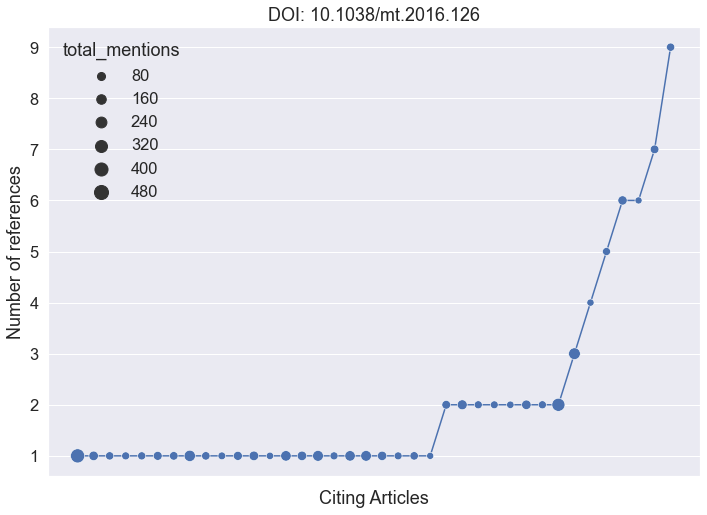

In [469]:
article_profile("10.1038/mt.2016.126")

In [395]:
doi = "10.1016/j.tibs.2018.01.001"
pdf = source_target_counts[source_target_counts.target==doi].copy()
pdf["ref_rank"] = pdf.mentions.rank(method="first")
pdf["weighted_mentions"] = pdf["weighted_mentions"]*100
pdf = pdf.sort_values("ref_rank")
pdf["author_status"] = ["None", "None", "None", "None", "None", "None", "None", "None", "None", "None", "None"]
pdf1 = pdf
pdf

,source,target,mentions,total_mentions,total_citations,weighted_mentions,weighted_citations,ref_rank,author_status
1819,10.1016/j.molmet.2019.02.001,10.1016/j.tibs.2018.01.001,1,75.0,58.0,1.333333,0.773333,1.0,None
2503,10.1038/s41467-018-03957-8,10.1016/j.tibs.2018.01.001,1,102.0,60.0,0.980392,0.588235,2.0,None
5266,10.1113/jp277761,10.1016/j.tibs.2018.01.001,1,124.0,90.0,0.806452,0.725806,3.0,None
7064,10.15252/embj.2019103499,10.1016/j.tibs.2018.01.001,1,110.0,78.0,0.909091,0.709091,4.0,None
2547,10.1038/s41467-019-09253-3,10.1016/j.tibs.2018.01.001,2,157.0,110.0,1.273885,1.401274,5.0,None
3415,10.1080/23818107.2019.1652851,10.1016/j.tibs.2018.01.001,2,55.0,32.0,3.636364,1.163636,6.0,None
5183,10.1111/nph.16134,10.1016/j.tibs.2018.01.001,3,283.0,152.0,1.060071,1.611307,7.0,None
5227,10.1111/tra.12635,10.1016/j.tibs.2018.01.001,3,90.0,35.0,3.333333,1.166667,8.0,None
607,10.1002/jimd.12083,10.1016/j.tibs.2018.01.001,7,293.0,149.0,2.389078,3.559727,9.0,None
1089,10.1007/s00418-018-1722-5,10.1016/j.tibs.2018.01.001,7,454.0,311.0,1.541850,4.795154,10.0,None


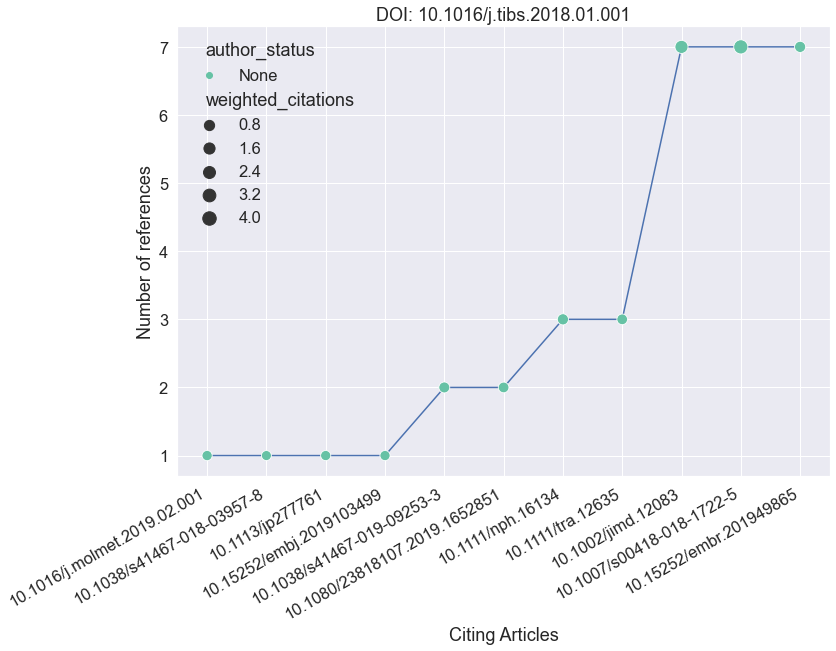

In [393]:
sns.lineplot(x="ref_rank", y="mentions", data=pdf, zorder=1)
sns.scatterplot(x="ref_rank", y="mentions", data=pdf, size="weighted_citations", hue="author_status", sizes=(100,200), legend=True, zorder=2, palette="Set2")

plt.xticks(ticks=range(1,len(pdf)+1), labels=pdf.source.tolist(), rotation=30, ha="right");
plt.title(f"DOI: {doi}")
plt.xlabel("Citing Articles")
plt.ylabel("Number of references");

In [418]:
doi = "10.1038/srep19230"
pdf = source_target_counts[source_target_counts.target==doi].copy()
pdf["ref_rank"] = pdf.mentions.rank(method="first")
pdf["weighted_mentions"] = pdf["weighted_mentions"]*100
pdf = pdf.sort_values("ref_rank")
pdf["author_status"] = ["None", "None", "None", "None", "None", "None", "None", "None", "Same Author", "None", "None", "None", "Same Author", "Collab", "Same Author"]
pdf2 = pdf
pdf

,source,target,mentions,total_mentions,total_citations,weighted_mentions,weighted_citations,ref_rank,author_status
2752,10.1038/s41598-017-06953-y,10.1038/srep19230,1,50.0,33.0,2.000000,0.660000,1.0,None
2769,10.1038/s41598-017-15944-y,10.1038/srep19230,1,80.0,47.0,1.250000,0.587500,2.0,None
3722,10.1101/134072,10.1038/srep19230,1,50.0,25.0,2.000000,0.500000,3.0,None
4608,10.1101/gad.304055.117,10.1038/srep19230,1,319.0,262.0,0.313480,0.821317,4.0,None
8723,10.3389/fnins.2018.00326,10.1038/srep19230,1,198.0,143.0,0.505051,0.722222,5.0,None
8941,10.3389/fnmol.2017.00046,10.1038/srep19230,1,111.0,66.0,0.900901,0.594595,6.0,None
9049,10.3389/fnmol.2019.00301,10.1038/srep19230,1,354.0,191.0,0.282486,0.539548,7.0,None
4535,10.1101/812115,10.1038/srep19230,2,117.0,88.0,1.709402,1.504274,8.0,None
7617,10.2142/biophysico.15.0_1,10.1038/srep19230,2,34.0,18.0,5.882353,1.058824,9.0,Same Author
8797,10.3389/fnins.2019.00335,10.1038/srep19230,2,466.0,262.0,0.429185,1.124464,10.0,None


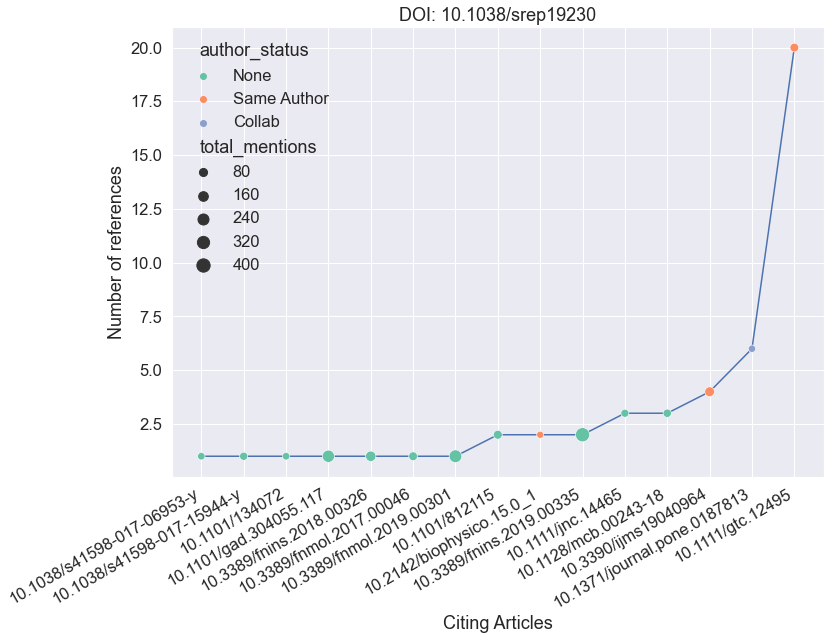

In [426]:
sns.lineplot(x="ref_rank", y="mentions", data=pdf, zorder=1)
sns.scatterplot(x="ref_rank", y="mentions", data=pdf, size="total_mentions", hue="author_status", sizes=(50,200), legend=True, zorder=2, palette="Set2")

plt.xticks(ticks=range(1,len(pdf)+1), labels=pdf.source.tolist(), rotation=30, ha="right");
plt.title(f"DOI: {doi}")
plt.xlabel("Citing Articles")
plt.ylabel("Number of references");

In [415]:
doi = "10.1186/s12284-017-0157-2"
pdf = source_target_counts[source_target_counts.target==doi].copy()
pdf["ref_rank"] = pdf.mentions.rank(method="first")
pdf["weighted_mentions"] = pdf["weighted_mentions"]*100
pdf = pdf.sort_values("ref_rank")
pdf["same_first_author"] = [False, False, False, False, False, False, False, False, True, True, True]
pdf["collaboration"] = [False, True, True, False, False, False, False, False, False, False, False]
pdf["author_status"] = ["None", "Collab", "Collab", "None", "None", "None", "None", "None", "Same Author", "Same Author", "Same Author"]
pdf3 = pdf
pdf

,source,target,mentions,total_mentions,total_citations,weighted_mentions,weighted_citations,ref_rank,same_first_author,collaboration,author_status
2209,10.1017/s0007114517001106,10.1186/s12284-017-0157-2,1,70.0,51.0,1.428571,0.728571,1.0,False,False,None
2914,10.1038/s41598-019-50344-4,10.1186/s12284-017-0157-2,1,93.0,68.0,1.075269,0.731183,2.0,False,True,Collab
4306,10.1101/530089,10.1186/s12284-017-0157-2,1,92.0,73.0,1.086957,0.793478,3.0,False,True,Collab
7542,10.21203/rs.3.rs-31258/v1,10.1186/s12284-017-0157-2,1,23.0,21.0,4.347826,0.913043,4.0,False,False,None
9892,10.3390/ijms20143489,10.1186/s12284-017-0157-2,1,65.0,60.0,1.538462,0.923077,5.0,False,False,None
10495,10.3945/cdn.117.001610,10.1186/s12284-017-0157-2,1,78.0,65.0,1.282051,0.833333,6.0,False,False,None
10864,10.7717/peerj.6477,10.1186/s12284-017-0157-2,1,78.0,55.0,1.282051,0.705128,7.0,False,False,None
3800,10.1101/2020.02.13.947515,10.1186/s12284-017-0157-2,3,83.0,61.0,3.614458,2.204819,8.0,False,False,None
7397,10.20944/preprints201809.0274.v1,10.1186/s12284-017-0157-2,6,102.0,85.0,5.882353,5.000000,9.0,True,False,Same Author
7191,10.15761/ifnm.1000252,10.1186/s12284-017-0157-2,7,79.0,57.0,8.860759,5.050633,10.0,True,False,Same Author


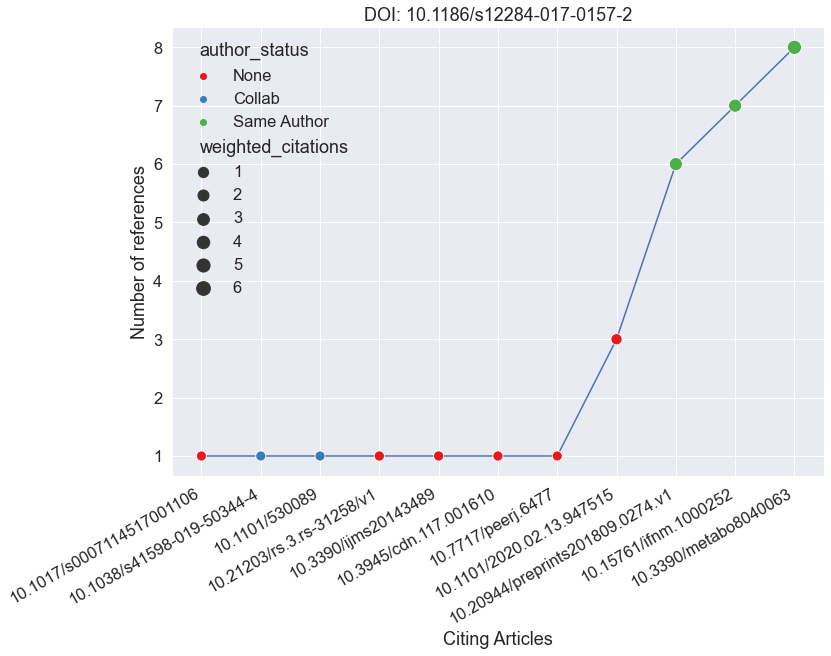

In [416]:
sns.lineplot(x="ref_rank", y="mentions", data=pdf, zorder=1)
sns.scatterplot(x="ref_rank", y="mentions", data=pdf, size="weighted_citations", hue="author_status", sizes=(100,200), legend=True, zorder=2, palette="Set1")

plt.xticks(ticks=range(1,len(pdf)+1), labels=pdf.source.tolist(), rotation=30, ha="right");
plt.title(f"DOI: {doi}")
plt.xlabel("Citing Articles")
plt.ylabel("Number of references");

In [403]:
pdf1["doi"] = "10.1016/j.tibs.2018.01.001"
pdf2["doi"] = "10.1038/srep19230"
pdf3["doi"] = "10.1186/s12284-017-0157-2"

pdf = pd.concat([pdf1, pdf2, pdf3])

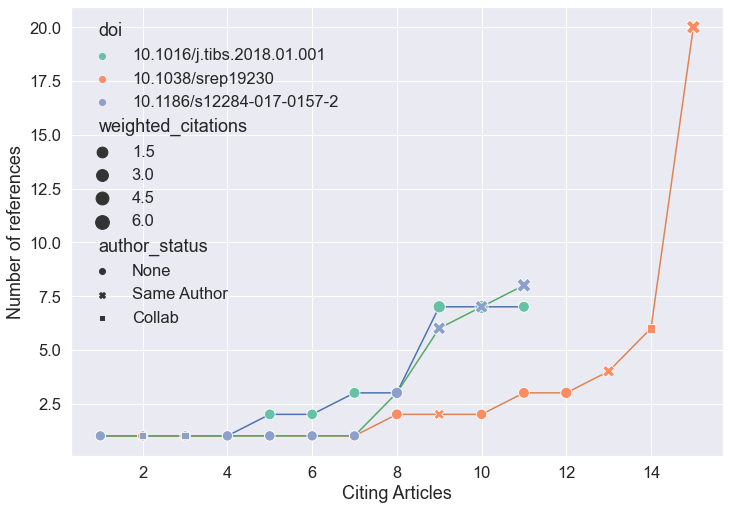

In [413]:
ax = sns.lineplot(x="ref_rank", y="mentions", hue="doi", data=pdf, zorder=1, legend=False)
sns.scatterplot(data=pdf,
                x="ref_rank",
                y="mentions",
                size="weighted_citations",
                style="author_status",
                hue="doi",
                sizes=(100,200), legend=True, zorder=2, palette="Set2", ax=ax)

# plt.xticks(ticks=range(1,len(pdf)+1), labels=pdf.source.tolist(), rotation=30, ha="right");
# plt.title(f"DOI: {doi}")
plt.xlabel("Citing Articles")
plt.ylabel("Number of references");